In [11]:
from empca_residuals import *
import gaia_tools.load as gload
from gaia_tools import xmatch
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
import matplotlib
import warnings
import os
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
font = {'family': 'serif',
        'weight': 'normal',
        'size'  :  18
}

matplotlib.rc('font',**font)


In [3]:
tgas_cat= gload.tgas()

In [4]:
tgas_cat.dtype

dtype([('hip', '>i4'), ('tycho2_id', 'S12'), ('solution_id', '>i8'), ('source_id', '>i8'), ('random_index', '>i8'), ('ref_epoch', '>f8'), ('ra', '>f8'), ('ra_error', '>f8'), ('dec', '>f8'), ('dec_error', '>f8'), ('parallax', '>f8'), ('parallax_error', '>f8'), ('pmra', '>f8'), ('pmra_error', '>f8'), ('pmdec', '>f8'), ('pmdec_error', '>f8'), ('ra_dec_corr', '>f4'), ('ra_parallax_corr', '>f4'), ('ra_pmra_corr', '>f4'), ('ra_pmdec_corr', '>f4'), ('dec_parallax_corr', '>f4'), ('dec_pmra_corr', '>f4'), ('dec_pmdec_corr', '>f4'), ('parallax_pmra_corr', '>f4'), ('parallax_pmdec_corr', '>f4'), ('pmra_pmdec_corr', '>f4'), ('astrometric_n_obs_al', '>i4'), ('astrometric_n_obs_ac', '>i4'), ('astrometric_n_good_obs_al', '>i4'), ('astrometric_n_good_obs_ac', '>i4'), ('astrometric_n_bad_obs_al', '>i4'), ('astrometric_n_bad_obs_ac', '>i4'), ('astrometric_delta_q', '>f4'), ('astrometric_excess_noise', '>f8'), ('astrometric_excess_noise_sig', '>f8'), ('astrometric_primary_flag', '?'), ('astrometric_releg

In [65]:
def all_match(central,catalog,epoch1=2000.,epoch2=2015.,maxdist=2):
    depoch= epoch2-epoch1
    if depoch != 0.:
        # Use proper motion to get both catalogs at the same time
        dra=catalog['pmra']/numpy.cos(catalog['dec']/180.*numpy.pi)\
            /3600000.*depoch
        ddec= catalog['pmdec']/3600000.*depoch
    cat_ras = catalog['ra']-dra
    ra_errs = catalog['ra_error']
    cat_decs = catalog['dec']-ddec
    dec_errs = catalog['dec_error']
    rabound_min = central['ra']-(maxdist/3600.)
    rabound_max = central['ra']+(maxdist/3600.)
    decbound_min = central['dec']-(maxdist/3600.)
    decbound_max = central['dec']+(maxdist/3600.)
    # Find right ascension match
    if rabound_min > 0. and rabound_max < 360.:
        ramatch = (cat_ras>rabound_min) & (cat_ras<rabound_max)
        raplusmatch = (cat_ras+ra_errs>rabound_min) & (cat_ras+ra_errs<rabound_max)
        raminusmatch = (cat_ras-ra_errs>rabound_min) & (cat_ras-ra_errs<rabound_max)
    elif rabound_min < 0. and rabound_max < 360.: 
        ramatch = ((cat_ras>0.) & (cat_ras<rabound_max)) | ((cat_ras>rabound_min+360.) & (cat_ras<360.))
        raplusmatch = ((cat_ras+ra_errs>0.) & (cat_ras+ra_errs<rabound_max)) | ((cat_ras+ra_errs>rabound_min+360.) & (cat_ras+ra_errs<360.))
        raminusmatch = ((cat_ras-ra_errs>0.) & (cat_ras-ra_errs<rabound_max)) | ((cat_ras-ra_errs>rabound_min+360.) & (cat_ras-ra_errs<360.))
    elif rabound_min > 0. and rabound_max > 360.:
        ramatch = ((cat_ras>rabound_min) & (cat_ras<360.)) | ((cat_ras>0.) & (cat_ras<rabound_max-360.))
        raplusmatch = ((cat_ras+ra_errs>rabound_min) & (cat_ras+ra_errs<360.)) | ((cat_ras+ra_errs>0.) & (cat_ras+ra_errs<rabound_max-360.))
        raminusmatch = ((cat_ras-ra_errs>rabound_min) & (cat_ras-ra_errs<360.)) | ((cat_ras-ra_errs>0.) & (cat_ras-ra_errs<rabound_max-360.))
    elif rabound_min < 0. and rabound_max > 360.:
        warnings.warn('Your range spans the whole sky in right ascension, exiting')
        ramatch = False
        raplusmatch = False
        raminusmatch = False
        
    if decbound_min > 0. and decbound_max < 360.:
        decmatch = (cat_decs>decbound_min) & (cat_decs<decbound_max)
        decplusmatch = (cat_decs+dec_errs>decbound_min) & (cat_decs+dec_errs<decbound_max)
        decminusmatch = (cat_decs-dec_errs>decbound_min) & (cat_decs-dec_errs<decbound_max)
    elif decbound_min < 0. and decbound_max < 360.: 
        decmatch = ((cat_decs>0.) & (cat_decs<decbound_max)) | ((cat_decs>decbound_min+360.) & (cat_decs<360.))
        decplusmatch = ((cat_decs+dec_errs>0.) & (cat_decs+dec_errs<decbound_max)) | ((cat_decs+dec_errs>decbound_min+360.) & (cat_decs+dec_errs<360.))
        decminusmatch = ((cat_decs-dec_errs>0.) & (cat_decs-dec_errs<decbound_max)) | ((cat_decs-dec_errs>decbound_min+360.) & (cat_decs-dec_errs<360.))
    elif decbound_min > 0. and decbound_max > 360.:
        decmatch = ((cat_decs>decbound_min) & (cat_decs<360.)) | ((cat_decs>0.) & (cat_decs<decbound_max-360.))
        decplusmatch = ((cat_decs+dec_errs>decbound_min) & (cat_decs+dec_errs<360.)) | ((cat_decs+dec_errs>0.) & (cat_decs+dec_errs<decbound_max-360.))
        decminusmatch = ((cat_decs-dec_errs>decbound_min) & (cat_decs-dec_errs<360.)) | ((cat_decs-dec_errs>0.) & (cat_decs-dec_errs<decbound_max-360.))
    elif decbound_min < 0. and decbound_max > 360.:
        warnings.warn('Your range spans the whole sky in declination, exiting')
        decmatch = False
        decplusmatch = False
        decminusmatch = False
    match = (ramatch & decmatch)
    match_err = ((raplusmatch & decmatch) | (raminusmatch & decmatch) | (ramatch & decplusmatch) | (raplusmatch & decplusmatch) | (raminusmatch & decplusmatch) | (ramatch & decminusmatch) | (raplusmatch & decminusmatch) | (raminusmatch & decminusmatch)) 
    match_err[match] = False
    return match, match_err

In [178]:
def plot_tgas_match(loc,dist,ang_rad,plot_err=True):
    match_in, match_err = all_match(loc,tgas_cat,epoch1=2000,epoch2=2015.,maxdist=ang_rad)
    plt.figure(figsize=(15,7))
    plt.subplot2grid((1,2),(0,0))
    if np.sum(match_err)!=0 and plot_err:
        plt.errorbar(tgas_cat[match_err]['ra'],tgas_cat[match_err]['dec'],alpha = 0.5,
                     xerr=tgas_cat[match_err]['ra_error'],yerr=tgas_cat[match_err]['dec_error'],
                     fmt='o',ecolor='m',color='m',label='{0} stars within errors'.format(np.sum(match_err)))
    if np.sum(match_in)!=0:
        plt.errorbar(tgas_cat[match_in]['ra'],tgas_cat[match_in]['dec'],
                     xerr=tgas_cat[match_in]['ra_error'],yerr=tgas_cat[match_in]['dec_error'],
                     fmt='o',ecolor='red',label='{0} stars match'.format(np.sum(match_in)))
    plt.plot(loc['ra'],loc['dec'],'o',color='c',markersize=10,label='cluster center')
    plt.legend(loc='best')
    plt.axvline(loc['ra']-ang_rad/3600.,ls='--')
    plt.axvline(loc['ra']+ang_rad/3600.,ls='--')
    plt.axhline(loc['dec']-ang_rad/3600.,ls='--')
    plt.axhline(loc['dec']+ang_rad/3600.,ls='--')
    plt.xlabel('right ascension')
    plt.ylabel('declination')
    plt.axis('equal')
    plt.subplot2grid((1,2),(0,1))
    if np.sum(match_err)!=0 and plot_err:    
        plt.errorbar(tgas_cat[match_err]['pmra'],tgas_cat[match_err]['pmdec'],alpha=0.5,
                     xerr=tgas_cat[match_err]['pmra_error'],yerr=tgas_cat[match_err]['pmdec_error'],
                     fmt='o',ecolor='m',color='m')
    if np.sum(match_in)!=0:
        plt.errorbar(tgas_cat[match_in]['pmra'],tgas_cat[match_in]['pmdec'],
                     xerr=tgas_cat[match_in]['pmra_error'],yerr=tgas_cat[match_in]['pmdec_error'],
                     fmt='o',ecolor='r',)
    plt.xlabel('right ascension proper motion')
    plt.ylabel('declination proper motion')
    plt.axis('equal')
    return match_in,match_err

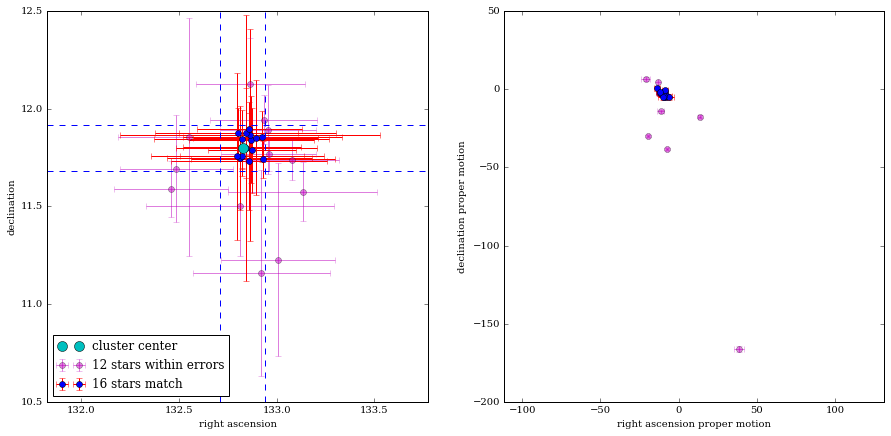

In [179]:
#M67
rad = 2. # cluster radius in pc
c = SkyCoord('08h51m18.0s','+11d48m00s',frame='icrs') # from Xin & Deng 2005
m67_loc = np.array([(c.ra.deg,c.dec.deg)], dtype=[('ra','float'),('dec','float')])
m67_dist = 986.279 # in pc from Pandey, Sandhu, Sagar & Battinelli 2010
m67_ang_rad = np.arctan(rad/m67_dist)*(180./np.pi)*3600. #angular radius in arcseconds
m67_match = plot_tgas_match(m67_loc,m67_dist,m67_ang_rad)

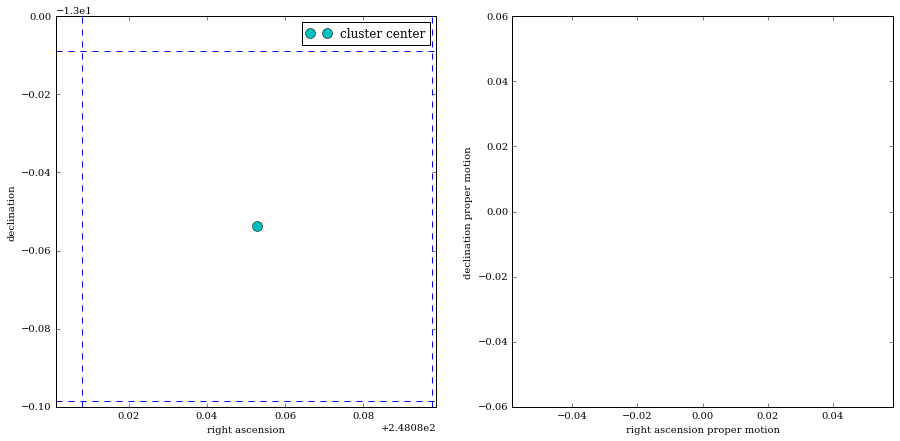

In [180]:
#M107
rad = 5. # cluster radius in pc
c = SkyCoord('16h32m31.86s','-13d03m13.6s',frame='icrs') # from Goldsbury et al 2010
m107_loc = np.array([(c.ra.deg,c.dec.deg)], dtype=[('ra','float'),('dec','float')])
m107_dist = 6.4*1e3 # in pc from A. Possenti 2010, unpublished
m107_ang_rad = np.arctan(rad/m107_dist)*(180./np.pi)*3600. #angular radius in arcseconds
m107_match = plot_tgas_match(m107_loc,m107_dist,m107_ang_rad)

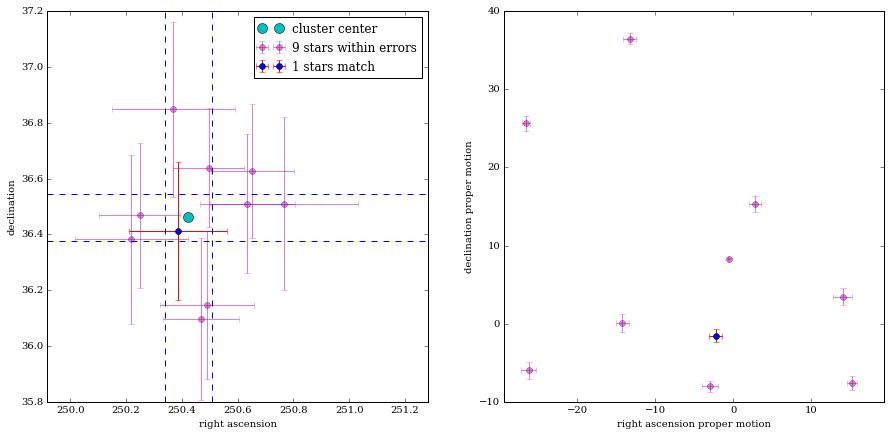

In [181]:
#M13
rad = 10. # cluster radius in pc
c = SkyCoord('16h41m41.634s','+36d27m40.75s',frame='icrs') # from Skrutskie et al 2006
m13_loc = np.array([(c.ra.deg,c.dec.deg)], dtype=[('ra','float'),('dec','float')])
m13_dist = 6.8*1e3 # in pc from Paust et al 2010
m13_ang_rad = np.arctan(rad/m13_dist)*(180./np.pi)*3600. #angular radius in arcseconds
m13_match = plot_tgas_match(m13_loc,m13_dist,m13_ang_rad)

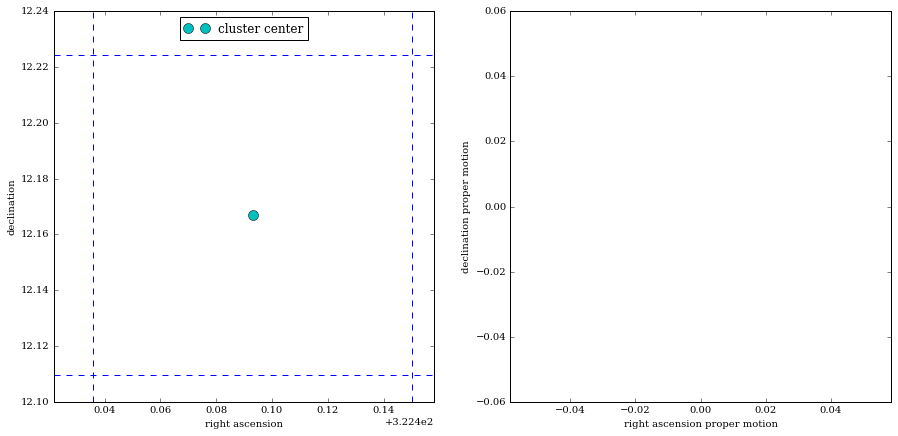

In [182]:
#M15
rad = 10. # cluster radius in pc
c = SkyCoord('21h29m58.33s','+12d10m01.2s',frame='icrs') # from Goldsbury et al 2010
m15_loc = np.array([(c.ra.deg,c.dec.deg)], dtype=[('ra','float'),('dec','float')])
m15_dist = 10*1e3 # in pc from Hessels et al 2007
m15_ang_rad = np.arctan(rad/m15_dist)*(180./np.pi)*3600. #angular radius in arcseconds
m15_match = plot_tgas_match(m15_loc,m15_dist,m15_ang_rad)

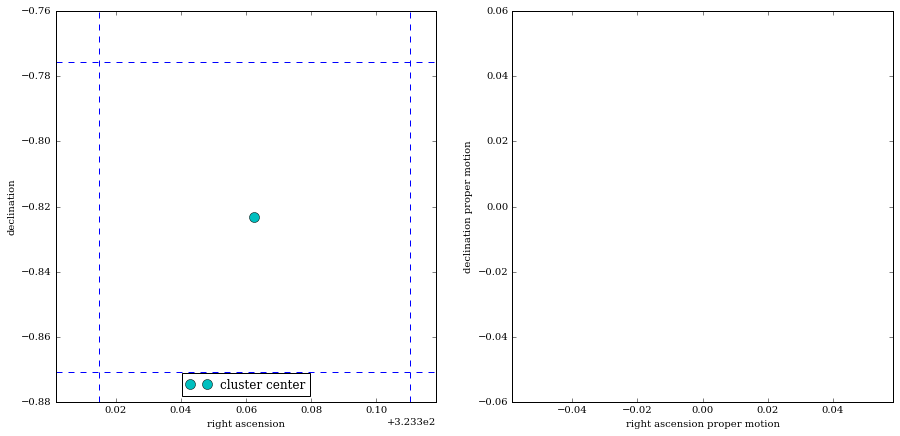

In [183]:
#M2
rad = 10. # cluster radius in pc
c = SkyCoord('21h33m27.02s','-00d49m23.7s',frame='icrs') # from Goldsbury et al 2010
m2_loc = np.array([(c.ra.deg,c.dec.deg)], dtype=[('ra','float'),('dec','float')])
m2_dist = 12*1e3 # in pc from Hessels et al 2007
m2_ang_rad = np.arctan(rad/m2_dist)*(180./np.pi)*3600. #angular radius in arcseconds
m2_match = plot_tgas_match(m2_loc,m2_dist,m2_ang_rad)

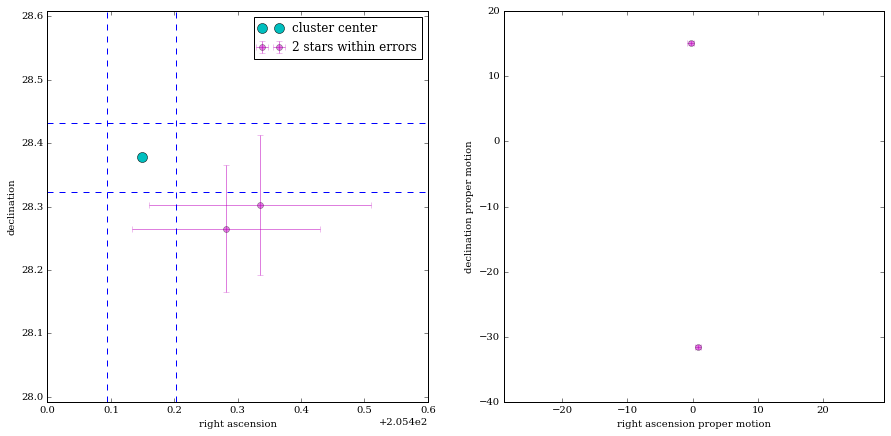

In [184]:
#M3
rad = 10. # cluster radius in pc
c = SkyCoord('13h42m11.62s','+28d22m38.2s',frame='icrs') # from Goldsbury et al 2010
m3_loc = np.array([(c.ra.deg,c.dec.deg)], dtype=[('ra','float'),('dec','float')])
m3_dist = 10.4*1e3 # in pc from Paust et al 2010
m3_ang_rad = np.arctan(rad/m3_dist)*(180./np.pi)*3600. #angular radius in arcseconds
m3_match = plot_tgas_match(m3_loc,m3_dist,m3_ang_rad)

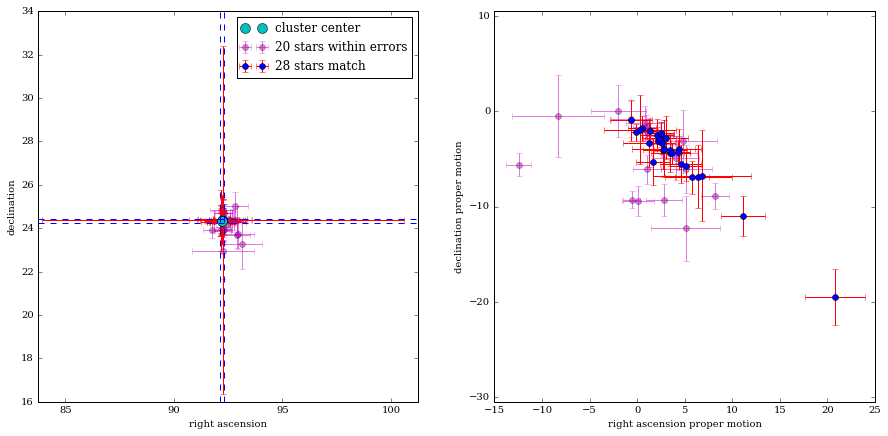

In [185]:
#M35
rad = 2. # cluster radius in pc
c = SkyCoord('06h08m54.0s','+24d20m00s',frame='icrs') # from Wu et al 2010
m35_loc = np.array([(c.ra.deg,c.dec.deg)], dtype=[('ra','float'),('dec','float')])
m35_dist = 1185.769 # in pc from Pandey et al 2010
m35_ang_rad = np.arctan(rad/m35_dist)*(180./np.pi)*3600. #angular radius in arcseconds
m35_match = plot_tgas_match(m35_loc,m35_dist,m35_ang_rad)

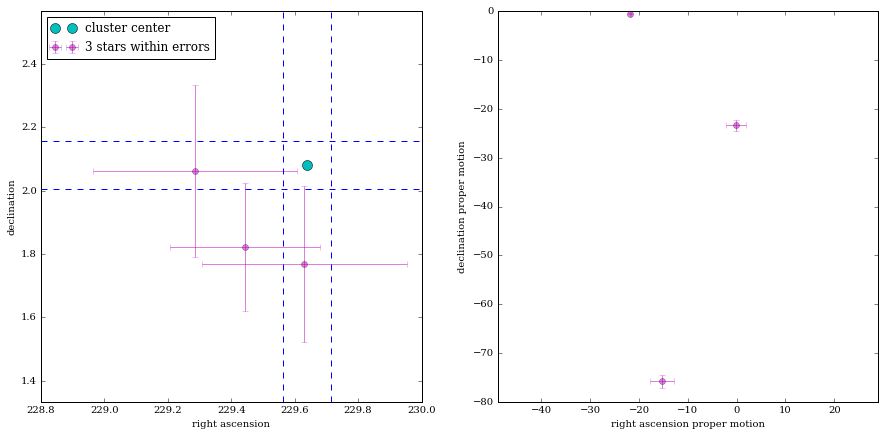

In [186]:
#M5
rad = 10. # cluster radius in pc
c = SkyCoord('15h18m33.22s','+02d04m51.7s',frame='icrs') # from Goldsbury et al 2010
m5_loc = np.array([(c.ra.deg,c.dec.deg)], dtype=[('ra','float'),('dec','float')])
m5_dist = 7.5*1e3 # in pc from Paust et al 2010
m5_ang_rad = np.arctan(rad/m5_dist)*(180./np.pi)*3600. #angular radius in arcseconds
m5_match = plot_tgas_match(m5_loc,m5_dist,m5_ang_rad)

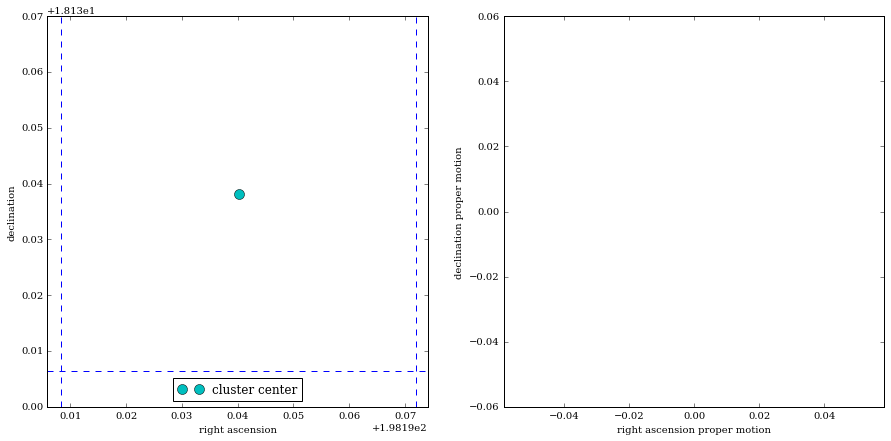

In [187]:
#M53
rad = 10. # cluster radius in pc
c = SkyCoord('13h12m55.25s','+18d10m05.4s',frame='icrs') # from Goldsbury et al 2010
m53_loc = np.array([(c.ra.deg,c.dec.deg)], dtype=[('ra','float'),('dec','float')])
m53_dist = 18*1e3 # in pc from Hessels et al 2010
m53_ang_rad = np.arctan(rad/m53_dist)*(180./np.pi)*3600. #angular radius in arcseconds
m53_match = plot_tgas_match(m53_loc,m53_dist,m53_ang_rad)

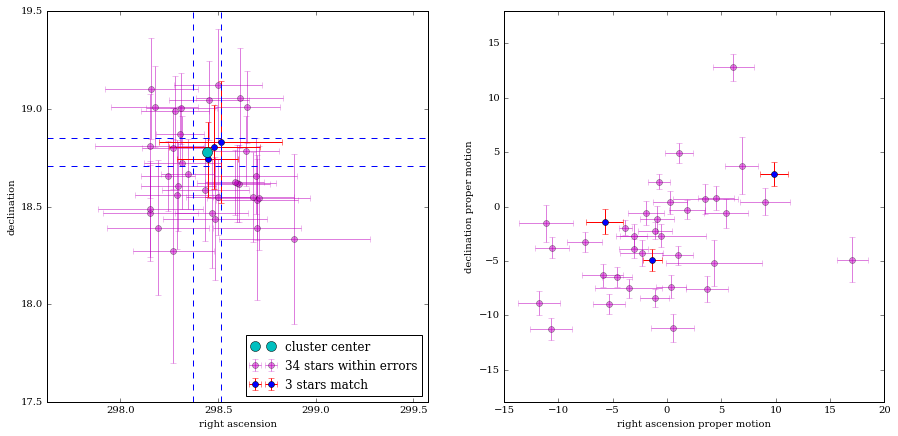

In [188]:
#M71
rad = 5. # cluster radius in pc
c = SkyCoord('19h53m46.49s','+18d46m45.1s',frame='icrs') # from Goldsbury et al 2010
m71_loc = np.array([(c.ra.deg,c.dec.deg)], dtype=[('ra','float'),('dec','float')])
m71_dist = 4*1e3 # in pc from Hessels et al 2010
m71_ang_rad = np.arctan(rad/m71_dist)*(180./np.pi)*3600. #angular radius in arcseconds
m71_match = plot_tgas_match(m71_loc,m71_dist,m71_ang_rad)

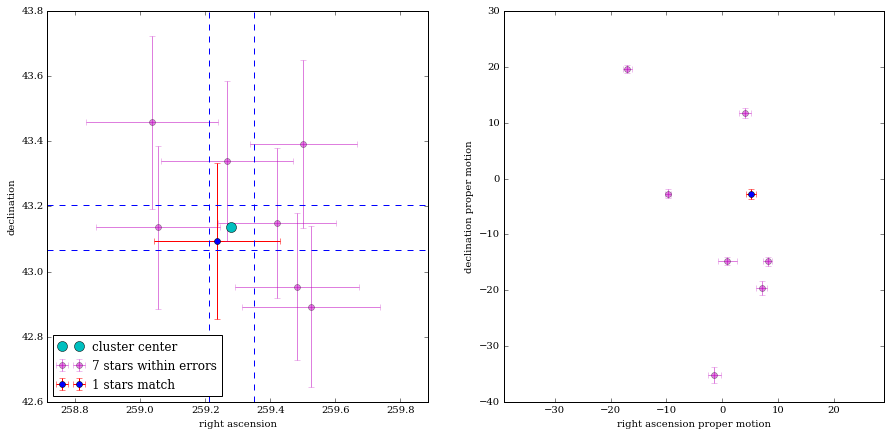

In [189]:
#M92
rad = 10. # cluster radius in pc
c = SkyCoord('17h17m07.39s','+43d08m09.4s',frame='icrs') # from Goldsbury et al 2010
m92_loc = np.array([(c.ra.deg,c.dec.deg)], dtype=[('ra','float'),('dec','float')])
m92_dist = 8.3*1e3 # in pc from Harris 1996 (2010 edition)
m92_ang_rad = np.arctan(rad/m92_dist)*(180./np.pi)*3600. #angular radius in arcseconds
m92_match = plot_tgas_match(m92_loc,m92_dist,m92_ang_rad)

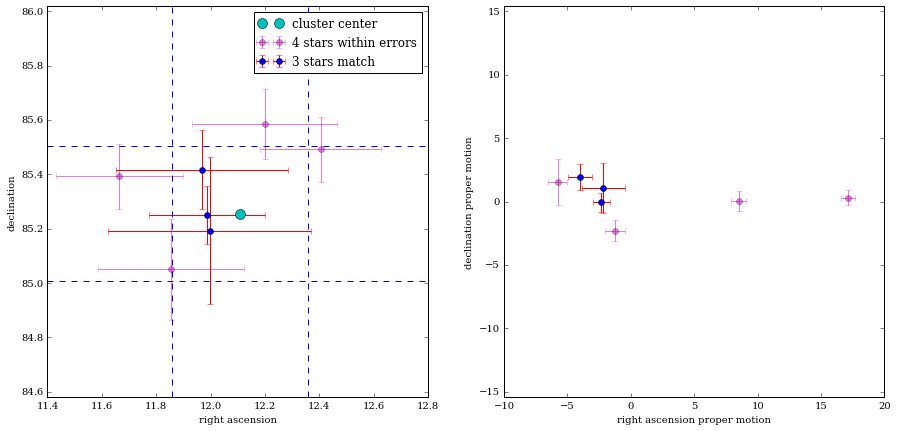

In [190]:
#N188
rad = 10. # cluster radius in pc
c = SkyCoord('00h48m26s','+85d15m18s',frame='icrs') # from Andreuzzi et al 2002
n188_loc = np.array([(c.ra.deg,c.dec.deg)], dtype=[('ra','float'),('dec','float')])
n188_dist = 2301.442 # in pc from Pandey et al 2010
n188_ang_rad = np.arctan(rad/n188_dist)*(180./np.pi)*3600. #angular radius in arcseconds
n188_match = plot_tgas_match(n188_loc,n188_dist,n188_ang_rad)

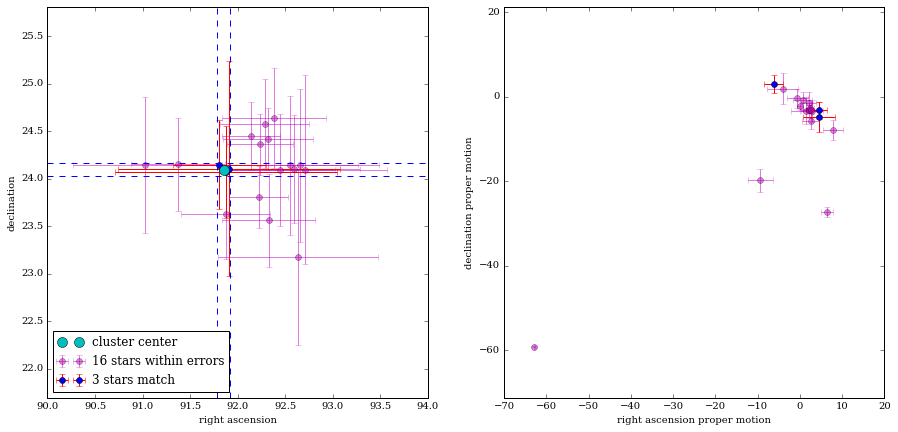

In [191]:
#N2158
rad = 10. # cluster radius in pc
c = SkyCoord('06h07m25s','+24d05m48s',frame='icrs') # from Xin et al 2005
n2158_loc = np.array([(c.ra.deg,c.dec.deg)], dtype=[('ra','float'),('dec','float')])
n2158_dist = 8472.274 # in pc from Pandey et al 2010
n2158_ang_rad = np.arctan(rad/n2158_dist)*(180./np.pi)*3600. #angular radius in arcseconds
n2158_match = plot_tgas_match(n2158_loc,n2158_dist,n2158_ang_rad)

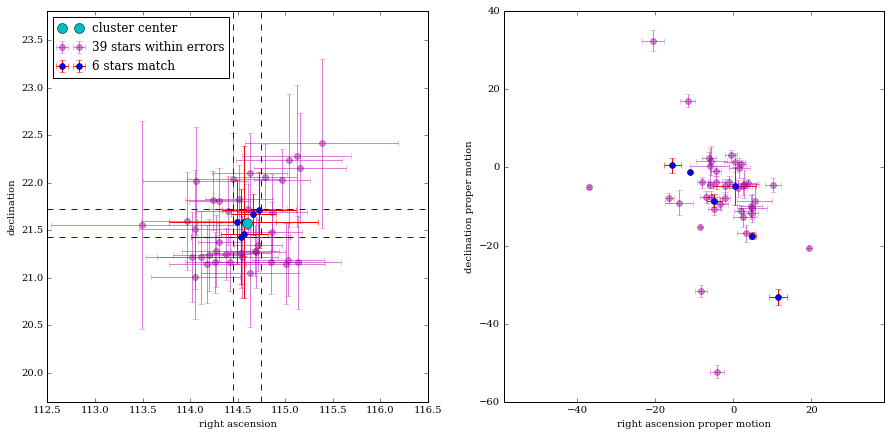

In [192]:
#N2420
rad = 5. # cluster radius in pc
c = SkyCoord('07h38m23s','+21d34m24s',frame='icrs') # from Xin et al 2005
n2420_loc = np.array([(c.ra.deg,c.dec.deg)], dtype=[('ra','float'),('dec','float')])
n2420_dist = 1944 # in pc from http://www.starobserver.eu/openclusters/ngc2420.html
n2420_ang_rad = np.arctan(rad/n2420_dist)*(180./np.pi)*3600. #angular radius in arcseconds
n2420_match = plot_tgas_match(n2420_loc,n2420_dist,n2420_ang_rad)

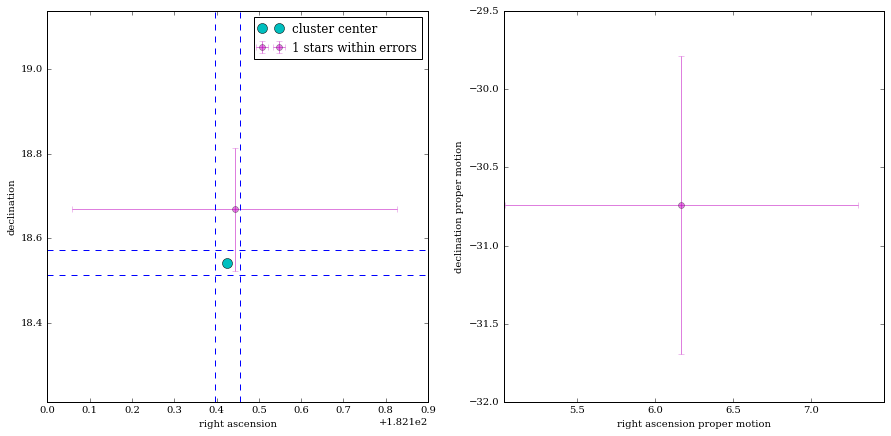

In [193]:
#N4147
rad = 10. # cluster radius in pc
c = SkyCoord('12h10m06.149s','+18d32m31.78s',frame='icrs') # from Skrutskie et al 2006
n4147_loc = np.array([(c.ra.deg,c.dec.deg)], dtype=[('ra','float'),('dec','float')])
n4147_dist = 19.3*1e3 # in pc from Harris 1996 (2010 edition)
n4147_ang_rad = np.arctan(rad/n4147_dist)*(180./np.pi)*3600. #angular radius in arcseconds
n4147_match = plot_tgas_match(n4147_loc,n4147_dist,n4147_ang_rad)

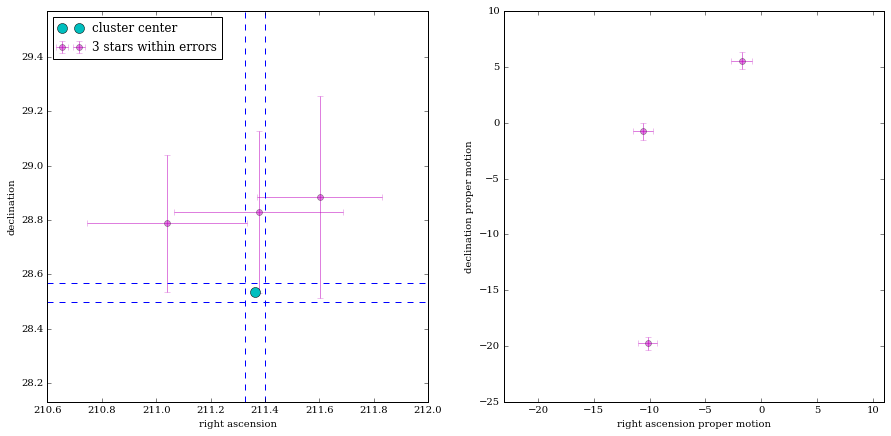

In [194]:
#N5466
rad = 10. # cluster radius in pc
c = SkyCoord('14h05m27.29s','+28d32m04s',frame='icrs') # from Goldsbury et al 2010
n5466_loc = np.array([(c.ra.deg,c.dec.deg)], dtype=[('ra','float'),('dec','float')])
n5466_dist = 16.0*1e3 # in pc from Harris 1996 (2010 edition)
n5466_ang_rad = np.arctan(rad/n5466_dist)*(180./np.pi)*3600. #angular radius in arcseconds
n5466_match = plot_tgas_match(n5466_loc,n5466_dist,n5466_ang_rad)

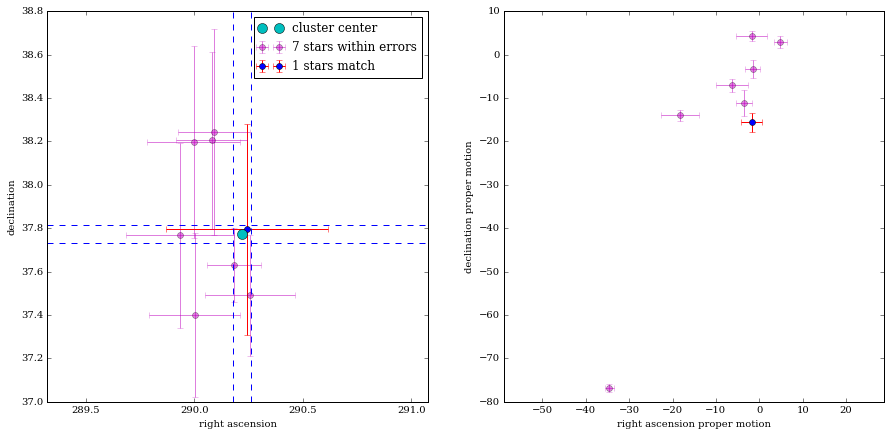

In [195]:
#N6791
rad = 5. # cluster radius in pc
c = SkyCoord('19h20m53s','+37d46m18s',frame='icrs') # from Xin et al 2005
n6791_loc = np.array([(c.ra.deg,c.dec.deg)], dtype=[('ra','float'),('dec','float')])
n6791_dist = 6918.310 # in pc from Pandey et al 2010
n6791_ang_rad = np.arctan(rad/n6791_dist)*(180./np.pi)*3600. #angular radius in arcseconds
n6791_match = plot_tgas_match(n6791_loc,n6791_dist,n6791_ang_rad)

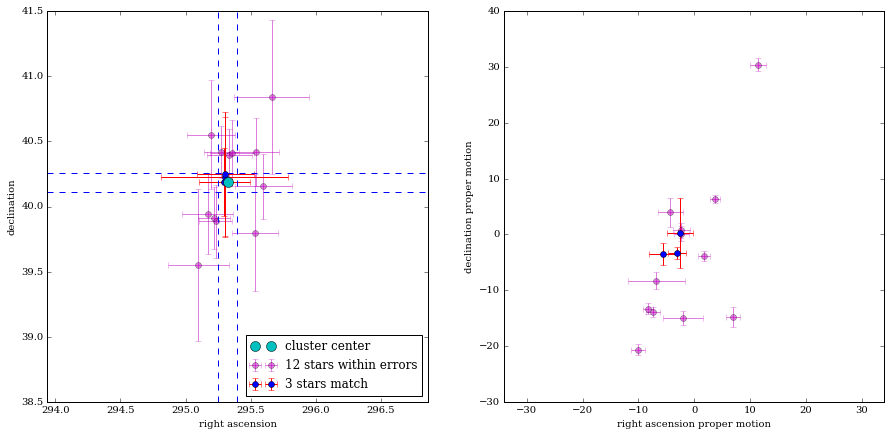

In [196]:
#N6819
rad = 3. # cluster radius in pc
c = SkyCoord('19h41m18s','+40d11m12s',frame='icrs') # from Xin et al 2005
n6819_loc = np.array([(c.ra.deg,c.dec.deg)], dtype=[('ra','float'),('dec','float')])
n6819_dist = 2360 # in pc from https://www.univie.ac.at/webda/cgi-bin/ocl_page.cgi?dirname=ngc6819
n6819_ang_rad = np.arctan(rad/n6819_dist)*(180./np.pi)*3600. #angular radius in arcseconds
n6819_match = plot_tgas_match(n6819_loc,n6819_dist,n6819_ang_rad)

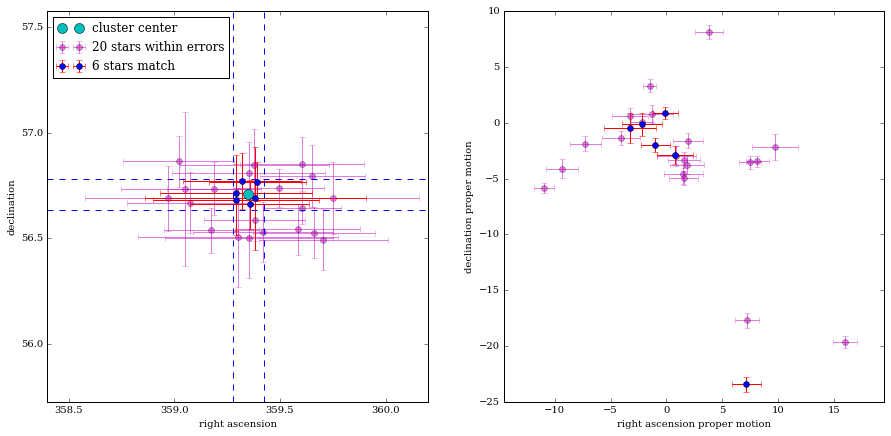

In [197]:
#N7789
rad = 3. # cluster radius in pc
c = SkyCoord('23h57m24s','+56d42m30s',frame='icrs') # from Xin et al 2005
n7789_loc = np.array([(c.ra.deg,c.dec.deg)], dtype=[('ra','float'),('dec','float')])
n7789_dist = 2337 # in pc from Kharchenko et al 2005
n7789_ang_rad = np.arctan(rad/n7789_dist)*(180./np.pi)*3600. #angular radius in arcseconds
n7789_match = plot_tgas_match(n7789_loc,n7789_dist,n7789_ang_rad)